In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Directory Info**

In [ ]:
import os

# Walk through SIH direcctory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/SIH"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 1 images in '/content/drive/MyDrive/SIH'.
There are 8 directories and 0 images in '/content/drive/MyDrive/SIH/Train'.
There are 0 directories and 1044 images in '/content/drive/MyDrive/SIH/Train/melanoma'.
There are 0 directories and 1071 images in '/content/drive/MyDrive/SIH/Train/pigmented benign keratosis'.
There are 0 directories and 128 images in '/content/drive/MyDrive/SIH/Train/dermatofibroma'.
There are 0 directories and 184 images in '/content/drive/MyDrive/SIH/Train/squamous cell carcinoma'.
There are 0 directories and 498 images in '/content/drive/MyDrive/SIH/Train/basal cell carcinoma'.
There are 0 directories and 144 images in '/content/drive/MyDrive/SIH/Train/vascular lesion'.
There are 0 directories and 120 images in '/content/drive/MyDrive/SIH/Train/actinic keratosis'.
There are 0 directories and 1460 images in '/content/drive/MyDrive/SIH/Train/nevus'.
There are 8 directories and 0 images in '/content/drive/MyDrive/SIH/Test'.
There are 0 dire

In [1]:
# Setting up the training and test directory paths.
train_dir = "/content/drive/MyDrive/SIH/Train/"
test_dir = "/content/drive/MyDrive/SIH/Test/"

 > **Class Names**

In [2]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)


['actinic keratosis' 'basal cell carcinoma' 'dermatofibroma' 'melanoma'
 'nevus' 'pigmented benign keratosis' 'squamous cell carcinoma'
 'vascular lesion']


# **Visualize !!**

In [3]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random, os

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (450, 600, 3)


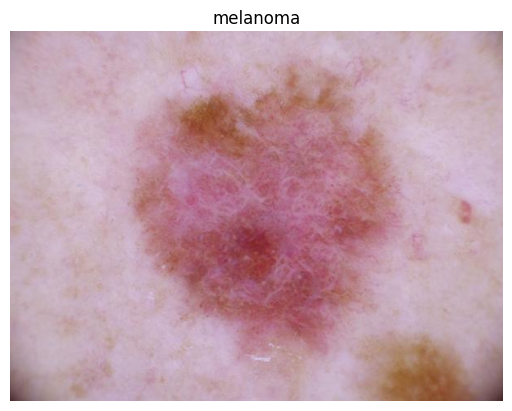

In [4]:
# View a random image from the training dataset
img = view_random_image(target_dir="/content/drive/MyDrive/SIH/Train/",
                        target_class="melanoma")

# **Fetch Train and Test Image Data**

In [ ]:
# Create augmented data generator instance
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen_augmented_2 = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=90, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True,
                                             vertical_flip = True)

train_data_augmented_2 = train_datagen_augmented_2.flow_from_directory(train_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 4649 images belonging to 8 classes.
Found 1158 images belonging to 8 classes.


# **Model Definition**

In [ ]:
# Creating a baseline model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Create our model (a clone of model_8, except to be multi-class)
model_4 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(8, activation='softmax') # changed to have 8 neurons (same as number of classes) and 'softmax' activation
])


# Compile the model
model_4.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit baseline model
history_4 = model_4.fit(train_data_augmented_2, # now 8 different classes
                        epochs=50,
                        steps_per_epoch=len(train_data_augmented_2),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/50
146/146 [==============================] - 76s 506ms/step - loss: 1.6127 - accuracy: 0.3822 - val_loss: 1.4420 - val_accuracy: 0.4836
Epoch 2/50
146/146 [==============================] - 75s 514ms/step - loss: 1.4267 - accuracy: 0.4756 - val_loss: 1.3915 - val_accuracy: 0.5009
Epoch 3/50
146/146 [==============================] - 75s 512ms/step - loss: 1.3765 - accuracy: 0.4881 - val_loss: 1.3310 - val_accuracy: 0.4940
Epoch 4/50
146/146 [==============================] - 75s 514ms/step - loss: 1.3394 - accuracy: 0.5046 - val_loss: 1.2898 - val_accuracy: 0.5155
Epoch 5/50
146/146 [==============================] - 76s 519ms/step - loss: 1.3254 - accuracy: 0.5035 - val_loss: 1.4542 - val_accuracy: 0.4378
Epoch 6/50
146/146 [==============================] - 75s 513ms/step - loss: 1.3158 - accuracy: 0.5231 - val_loss: 1.3660 - val_accuracy: 0.4767
Epoch 7/50
146/146 [==============================] - 78s 532ms/step - loss: 1.2798 - accuracy: 0.5246 - val_loss: 1.2097 - val_ac

# **Model Evaluation**

In [ ]:
# Evaluate on the test data
model_4.evaluate(test_data)

37/37 [==============================] - 4s 106ms/step - loss: 1.0410 - accuracy: 0.6157


[1.0409833192825317, 0.6157167553901672]

# **Curve Plotting**

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

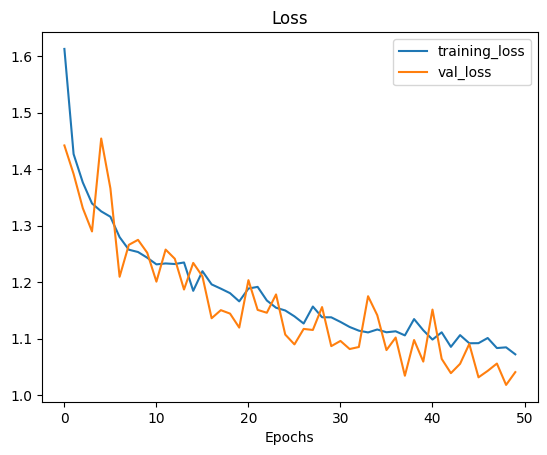

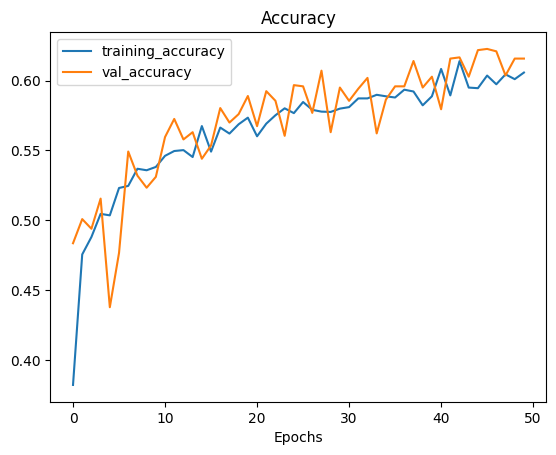

In [ ]:
plot_loss_curves(history_4)

# **Predict on New Image Data**

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=[224, 224]):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = img_shape)

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [ ]:
# Function to work with multi-class
def pred_and_plot(model, filename, class_names, img_shape=[224, 224]):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename, img_shape)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))
  print(pred)

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 322ms/step
[[0.01319115 0.60975    0.11683629 0.03011559 0.0093983  0.19986235
  0.01981053 0.00103576]]


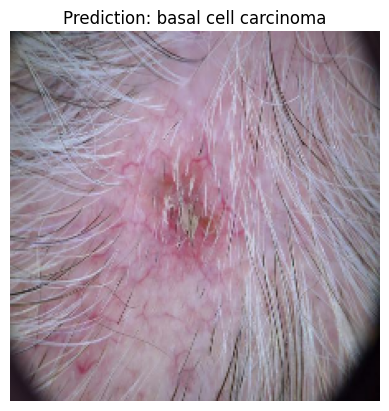

In [ ]:
pred_and_plot(model_4, "/content/drive/MyDrive/SIH/try/basal cell carcinoma.JPG", class_names)

1/1 [==============================] - 0s 44ms/step
[[2.6657969e-11 5.0228454e-07 3.3188140e-08 7.4377638e-01 2.5606948e-01
  7.3765885e-05 7.9338744e-05 5.0623271e-07]]


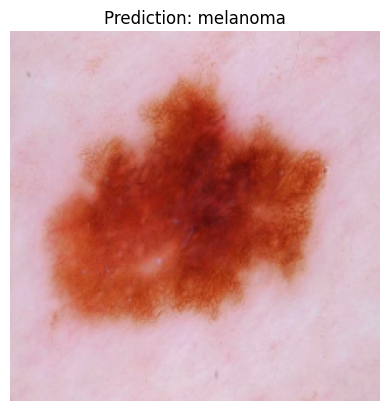

In [ ]:
pred_and_plot(model_4, "/content/drive/MyDrive/SIH/try/melanoma.JPG", class_names)

# **Save Model**

In [ ]:
# Save model
model_4.save("/content/drive/MyDrive/SIH/saved_trained_model")